## Poynting-Robertson drag

Here we will examine a simple orbital dynamics problem with Poynting-Robertson drag in order to characterize the slimplectic Galerkin-Gauss-Lobatto integrator. The Lagrangian for a central gravitional potential (with mass $M_\odot$ is given by
$$ L = \frac{1}{2} m \dot{\mathbf q}^2 + (1-\beta)\frac{GM_{\odot}m}{r}$$
with nonconservative potential given by (up to terms linear in $v/c$)
$$ K = -\frac{\beta G M m }{c r_+^2} \left[\left(\delta_{ij} + \frac{q_{i+} q_{j+}}{r_+^2}\right)\dot{q}_+^i q_-^j\right] = -\frac{\beta G M_\odot m }{c r_+^2} \left[\dot{{\mathbf q}}_+ \cdot {\mathbf q}_- + \frac{1}{r_+^2}(\dot{{\mathbf q}}_+ \cdot {\mathbf q}_+)({\mathbf q}_+ \cdot {\mathbf q}_-)\right]$$
where 
$$\beta \simeq \frac{3L_\odot}{8\pi c \rho G M_\odot d} \simeq 0.0576906 \left(\frac{\rho}{2\, {\rm g}\,{\rm cm}^{-3}} \right)^{-1} \left(\frac{d}{10^{-3} {\rm cm}} \right)^{-1}.$$
Here, $L_\odot$ is the sun's luminosity, $c$ is the speed of light, $\rho$ is the density of the dust grain, and $d$ is the diameter of the dust grain.


We adopt Cartesian coordinates for the orbital dynamics with
${\mathbf q} = x \hat{\mathbf x} + y \hat{\mathbf y} + z \hat{\mathbf z}$, with $r = ({\mathbf q} \cdot {\mathbf q})^{1/2}$.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np, matplotlib.pyplot as plt
import orbit_util as orbit
from slimpletic import make_solver
import jax.numpy as jnp

In [2]:
plot_path = './'

In [3]:
# Parameters
G = 39.478758435  #(in AU^3/M_sun/yr^2))
M_Sun = 1.0  #(in solar masses)
rho = 2.0  #(in g/cm^3)
d = 5.0e-3  #(in cm)
beta = 0.0576906 * (2.0 / rho) * (1.0e-3 / d)  #(dimensionless)
c = 63241.3  #(in AU/yr)
m = 1.

### Slimplectic integration

In [4]:
def lagrangian(q, v, t):
    return 0.5 * jnp.dot(v, v) + (1.0 - beta) * G * M_Sun / jnp.dot(q, q) ** 0.5


def nonconservative(qp, qm, vp, vm, t):
    a = jnp.dot(vp, qm) + jnp.dot(vp, qp) * jnp.dot(qp, qm) / jnp.dot(qp, qp)
    b = -beta * G * M_Sun / c / jnp.dot(qp, qp)
    return a * b

In [5]:
# Specify time samples at which the numerical solution is to be given and provide initial data.

# We take the initial orbital parameters to be given by:
# a=1, e=0, i=0, omega=0, Omega=0, M=0
q0, v0 = orbit.Calc_Cartesian(1.0, 0.2, 0.0, 0.0, 0.0, 0.0, (1.0 - beta) * G * M_Sun)
pi0 = v0  # Dust taken to have unit mass

# Time samples (in years)
t_end = 6000
dt = 0.01
t = np.arange(0, t_end + dt, dt)

In [6]:
# Create an instance of the GalerkinGaussLobatto class and call it `pr` for Poynting-Robinson
# We will focus on motion in the x-y plane since the direction of the orbital angular momentum
# can be shown to be preserved analytically. All integrators considered here preserve this
# except for the 2nd order implicit slimplectic integrator. We shall not consider this further here.
pr = make_solver(
    r=0,
    lagrangian=lagrangian,
    k_potential=nonconservative,
    dt=dt
)

In [7]:
# Now integrate the 2nd order slimplectic integrator
q_slim2, pi_slim2 = pr.integrate(q0[:2], pi0[:2], t0=t[0], iterations=t.size - 1)
q_slim2 = q_slim2.T
pi_slim2 = pi_slim2.T

PANDAS SolverScan.integrate recompiled
PANDAS SolverScan.integrate verified
PANDAS SolverScan.integrate t_samples computed
PANDAS SolverScan.integrate scanned


In [8]:
pr_r1 = make_solver(
    r=1,
    lagrangian=lagrangian,
    k_potential=nonconservative,
    dt=dt
)

# ...and then integrate to get the corresponding numerical solution
q_slim4, pi_slim4 = pr_r1.integrate(q0[:2], pi0[:2], t0=t[0], iterations=t.size - 1)
q_slim4 = q_slim4.T
pi_slim4 = pi_slim4.T

PANDAS SolverScan.integrate recompiled
PANDAS SolverScan.integrate verified
PANDAS SolverScan.integrate t_samples computed
PANDAS SolverScan.integrate scanned


We don't have an exact solution to compare our numerical results against. In lieu of this, we use a 6th order implicit slimplectic integrator as our "fiducial" solution for comparisons made below.

In [9]:
pr_r2 = make_solver(
    r=2,
    lagrangian=lagrangian,
    k_potential=nonconservative,
    dt=dt
)

q_slim6, pi_slim6 = pr_r2.integrate(q0[:2], pi0[:2], t0=t[0], iterations=t.size - 1)
q_slim6 = q_slim6.T
pi_slim6 = pi_slim6.T

PANDAS SolverScan.integrate recompiled
PANDAS SolverScan.integrate verified
PANDAS SolverScan.integrate t_samples computed
PANDAS SolverScan.integrate scanned


### Runge-Kutta integration

Generate the 2nd and 4th order Runge-Kutta solutions to compare below with output from the slimplectic integrators.

In [10]:
from rk import RungeKutta2, RungeKutta4

rk2 = RungeKutta2()
rk4 = RungeKutta4()


# Define the derivative operator
def dydt(time, y):
    deriv = np.zeros(4)
    [q_x, q_y, v_x, v_y] = y
    r = (q_x * q_x + q_y * q_y) ** 0.5
    deriv[0] = v_x
    deriv[1] = v_y
    deriv[2] = -(1. - beta) * G * M_Sun * q_x / (r * r * r)
    deriv[2] -= (beta * G * M_Sun / (c * r * r)) * (v_x + q_x * (q_x * v_x + q_y * v_y) / (r * r))
    deriv[3] = -(1. - beta) * G * M_Sun * q_y / (r * r * r)
    deriv[3] -= (beta * G * M_Sun / (c * r * r)) * (v_y + q_y * (q_x * v_x + q_y * v_y) / (r * r))

    return deriv


# Integrate
q_rk2, v_rk2 = rk2.integrate(q0[:2], v0[:2], t, dydt)
q_rk4, v_rk4 = rk4.integrate(q0[:2], v0[:2], t, dydt)

# Please note that q and pi are outputs of the slimplectic integration, 
# while q and v are output from the Runge-Kutta integrators.

## Comparison plots

Plot the $x$-component of the orbital vector ${\mathbf q}(t)$ for the 2nd and 4th order slimplectic and RK integrators along with the "fiducial" 6th order slimplectic solution.

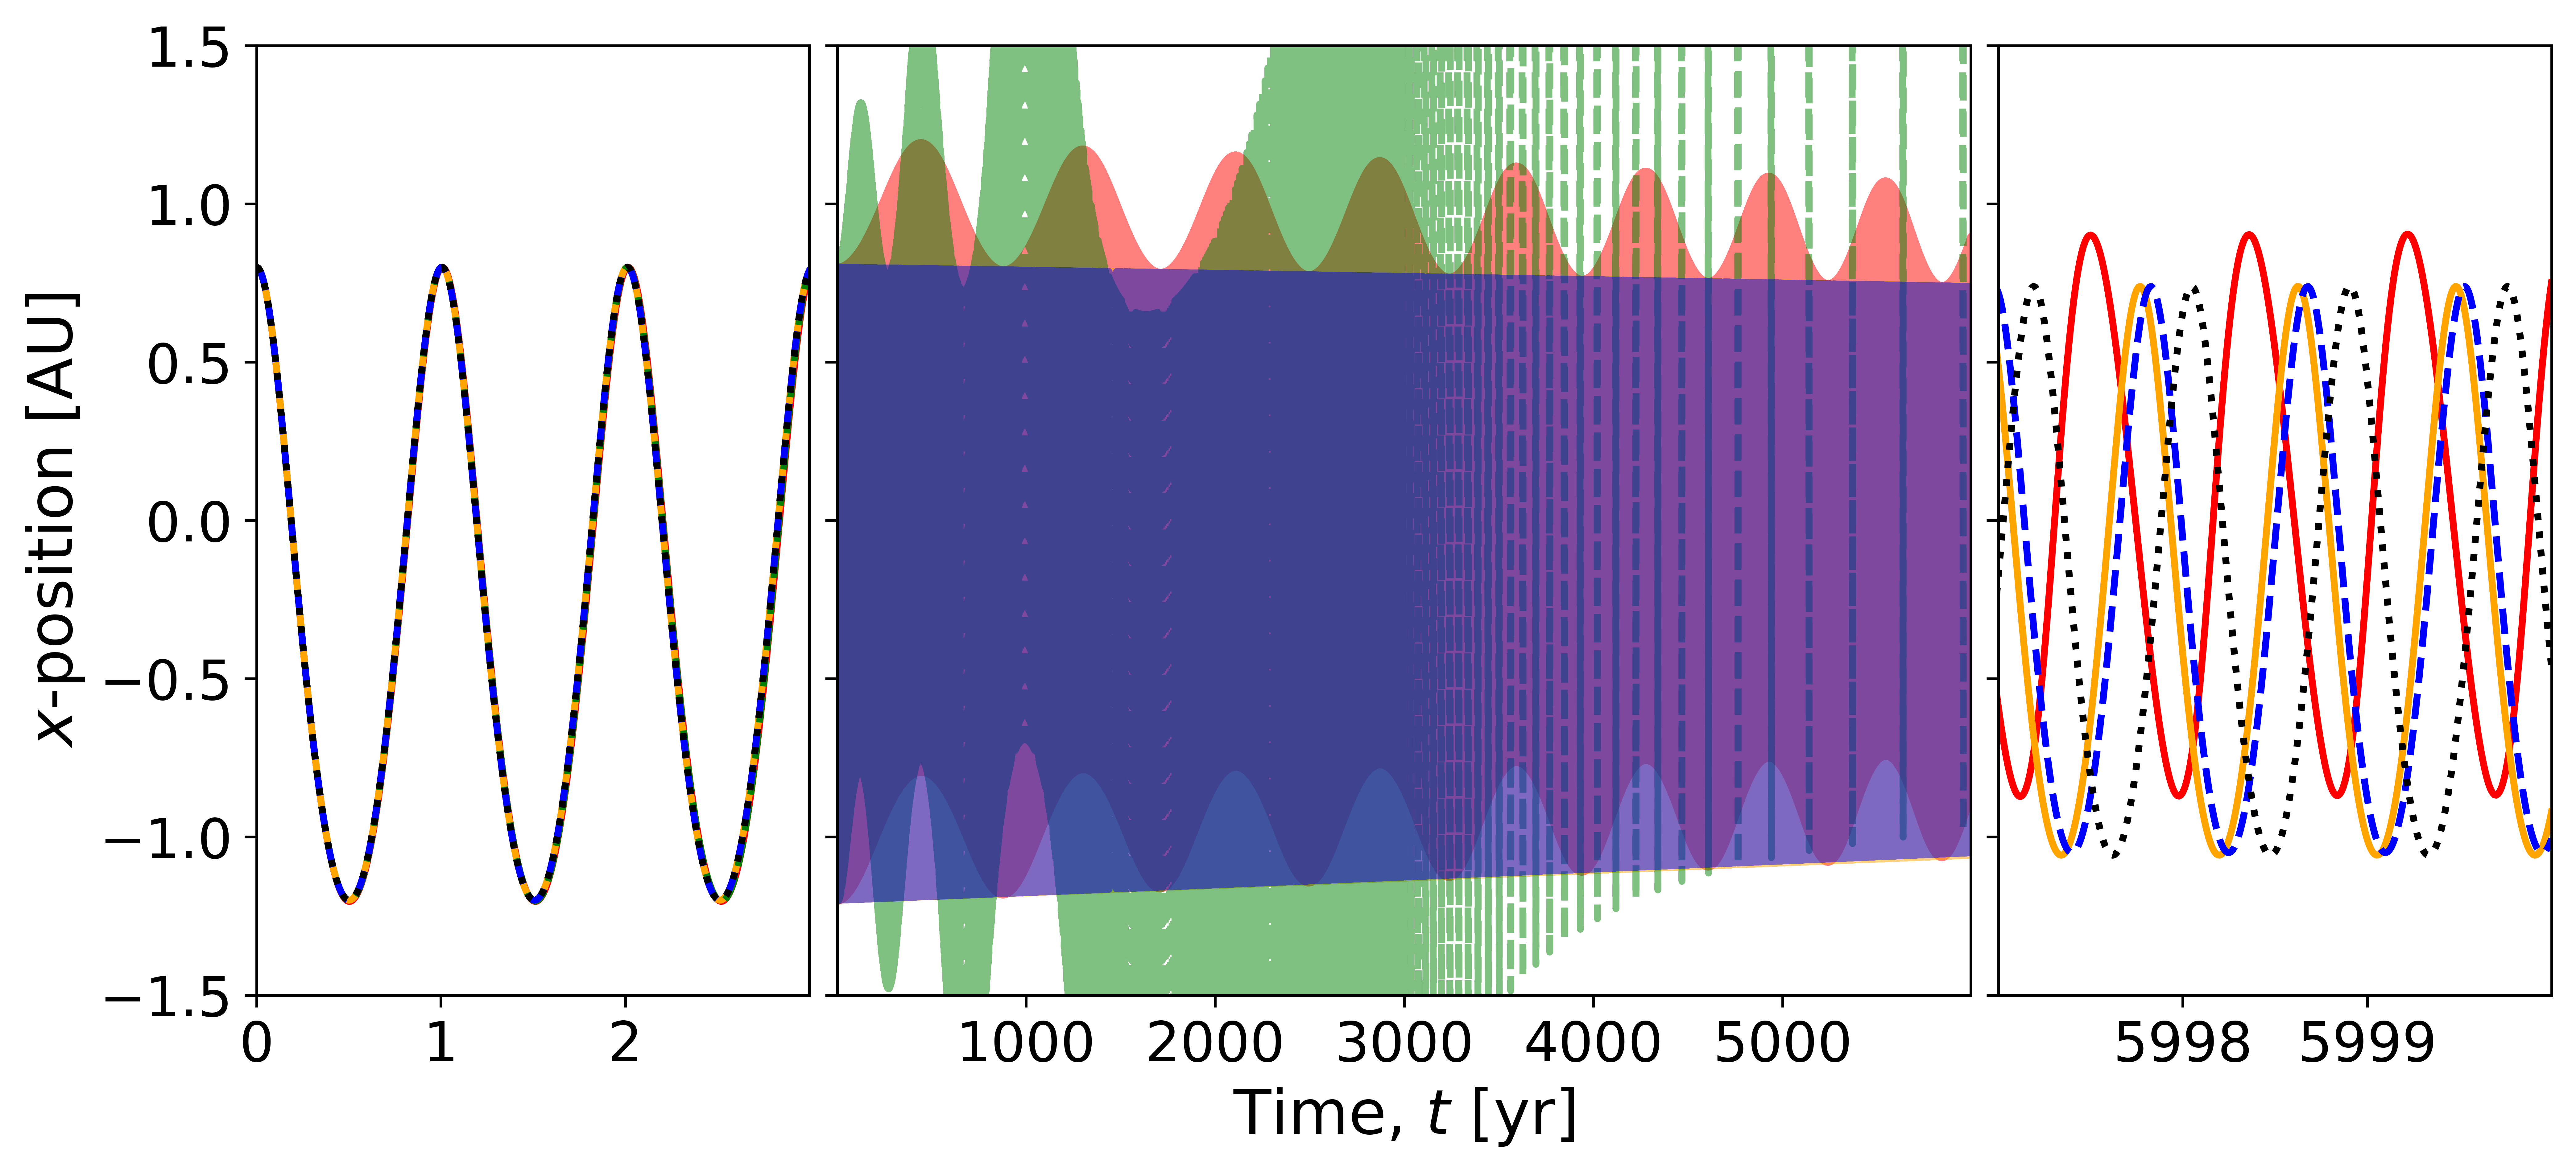

In [11]:
fig1 = plt.figure(figsize=(12, 5), dpi=800)
fig1.subplots_adjust(wspace=0.05)

ax1a = fig1.add_subplot(1, 4, 1)
ax1a.set_ylim(-1.5, 1.5)
ax1a.set_xlim(0, 3)
ax1a.set_xticks([0, 1, 2])
ax1a.plot(t, q_slim2[0], 'r-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim6[0], 'k:', linewidth=2.0, rasterized=True)

ax1b = fig1.add_subplot(1, 4, (2, 3))
plt.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-1.5, 1.5)
ax1b.set_xlim(3, 5995)
ax1b.set_xticks([1000, 2000, 3000, 4000, 5000])
ax1b.plot(t, q_slim2[0], 'r-', linewidth=2.0, alpha=.5, rasterized=True)
ax1b.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, alpha=.5, rasterized=True)
ax1b.plot(t, q_rk2[0], 'g--', linewidth=2.0, alpha=.5, rasterized=True)
ax1b.plot(t, q_rk4[0], 'b--', linewidth=2.0, alpha=.5, rasterized=True)

ax1c = fig1.add_subplot(1, 4, 4)
plt.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-1.5, 1.5)
ax1c.set_xlim(5997, 6000)
ax1c.set_xticks([5998, 5999])
ax1c.get_xaxis().get_major_formatter().set_useOffset(False)
ax1c.plot(t, q_slim2[0], 'r-', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_slim6[0], 'k:', linewidth=2.0, rasterized=True)

ax1a.tick_params(axis='both', which='major', labelsize=16)
ax1b.tick_params(axis='both', which='major', labelsize=16)
ax1c.tick_params(axis='both', which='major', labelsize=16)

ax1b.set_xlabel('Time, $t$ [yr]', fontsize=18)
ax1a.set_ylabel('$x$-position [AU]', fontsize=18);

In [12]:
#fig1.savefig(plot_path + "PRDrag_xLong.pdf", transparent=True,bbox_inches='tight')

Let's plot the orbital phase of the dust particle for the different integrators.

In [13]:
phi_slim2 = orbit.phase(q_slim2[0], q_slim2[1])
phi_slim4 = orbit.phase(q_slim4[0], q_slim4[1])
phi_slim6 = orbit.phase(q_slim6[0], q_slim6[1])
phi_rk2 = orbit.phase(q_rk2[0], q_rk2[1])
phi_rk4 = orbit.phase(q_rk4[0], q_rk4[1])

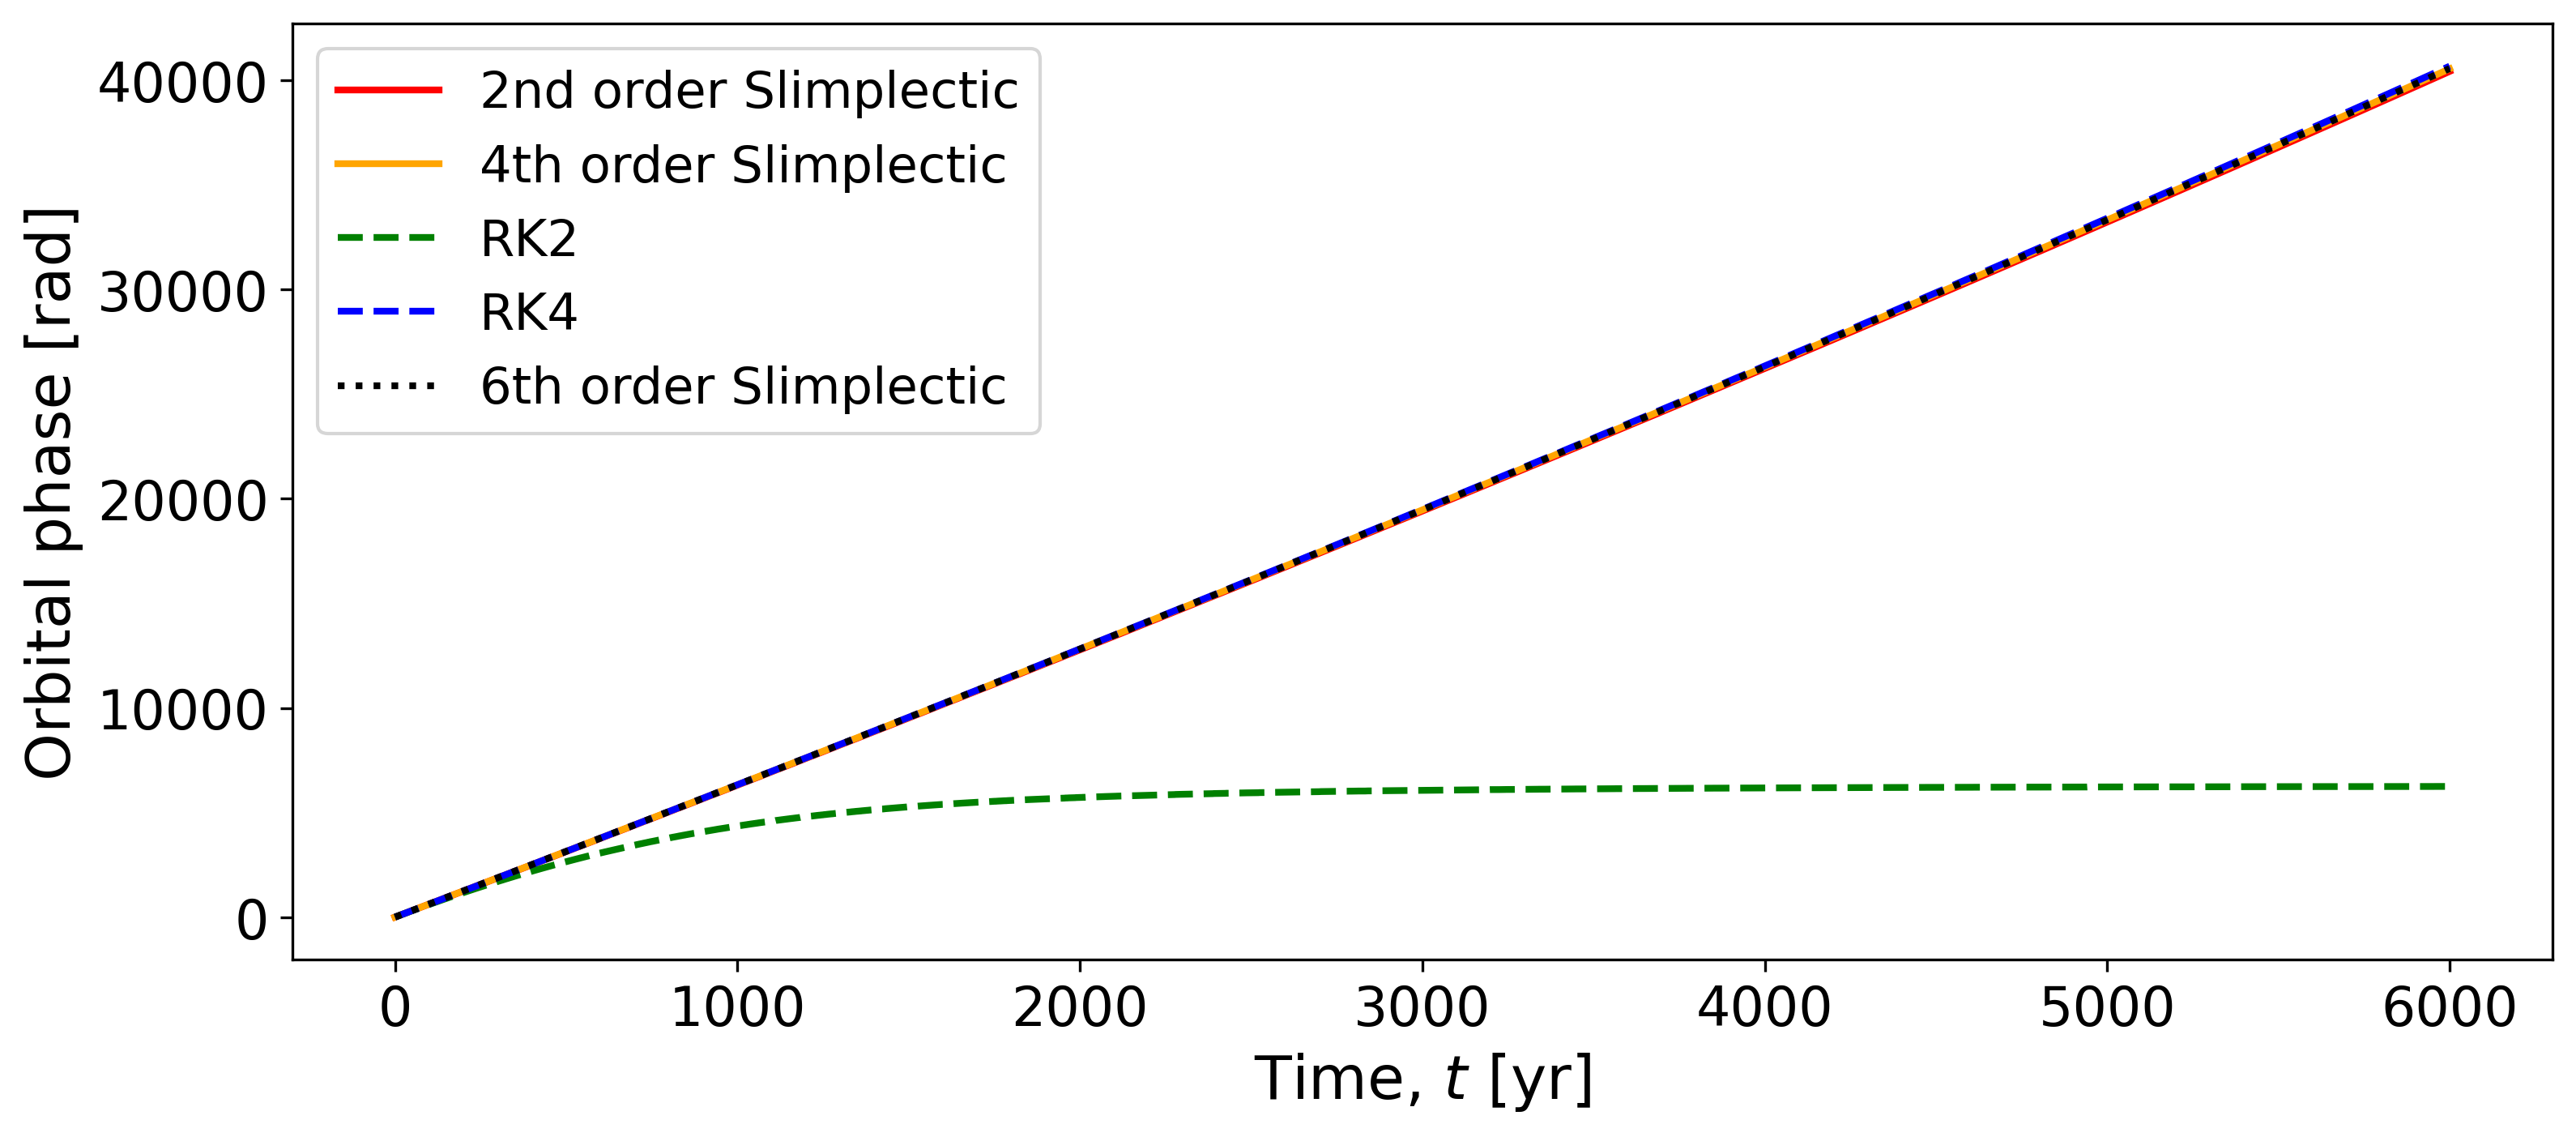

In [14]:
fig1_phase = plt.figure(figsize=(12, 5), dpi=300)
ax1d = fig1_phase.add_subplot(111)

ax1d.plot(t, phi_slim2, 'r-', linewidth=2.0, rasterized=True, label='2nd order Slimplectic');
ax1d.plot(t, phi_slim4, '-', color='orange', linewidth=2.0, rasterized=True, label='4th order Slimplectic');
ax1d.plot(t, phi_rk2, 'g--', linewidth=2.0, rasterized=True, label='RK2');
ax1d.plot(t, phi_rk4, 'b--', linewidth=2.0, rasterized=True, label='RK4');

ax1d.plot(t, phi_slim6, 'k:', linewidth=2.0, rasterized=True, label='6th order Slimplectic');
ax1d.set_xlabel('Time, $t$ [yr]', fontsize=18);
ax1d.set_ylabel('Orbital phase [rad]', fontsize=18);
ax1d.legend(loc='upper left', prop={'size': 15});

ax1d.tick_params(axis='both', which='major', labelsize=16)

In [15]:
# Energy function
def Energy(q, v):
    return 0.5 * m * (v[0] ** 2 + v[1] ** 2) - (1. - beta) * G * M_Sun * m / np.sqrt(q[0] ** 2 + q[1] ** 2)


# Energies from different integrators
E_slim2 = Energy(q_slim2, pi_slim2 / m)
E_slim4 = Energy(q_slim4, pi_slim4 / m)
E_slim6 = Energy(q_slim6, pi_slim6 / m)

E_rk2 = Energy(q_rk2, v_rk2)
E_rk4 = Energy(q_rk4, v_rk4)

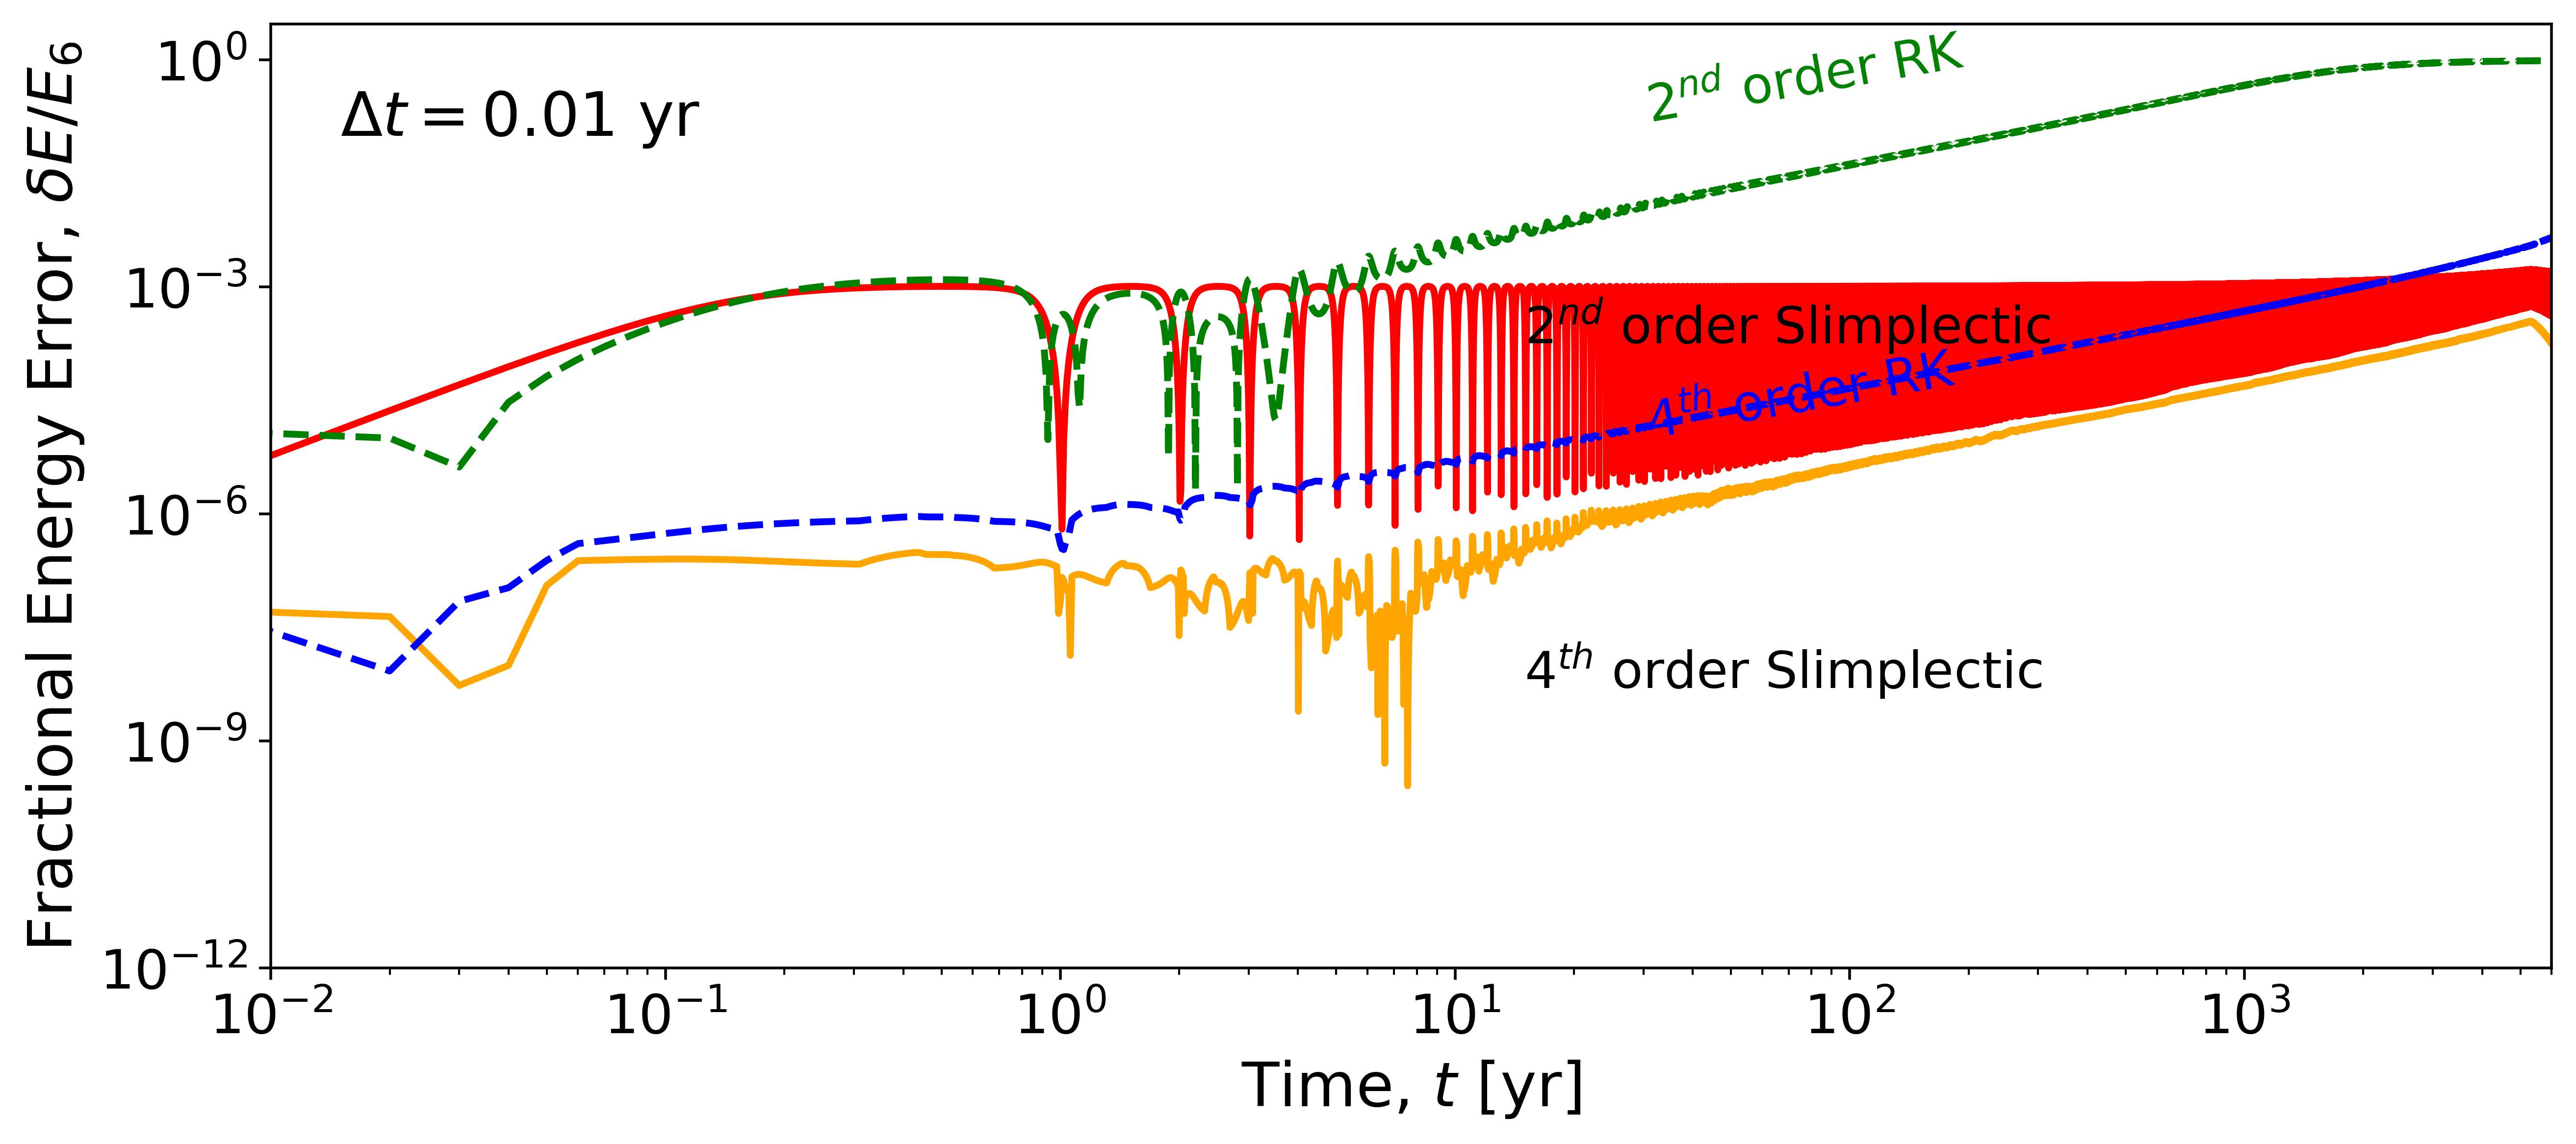

In [16]:
fig2 = plt.figure(figsize=(12, 5), dpi=500)
ax2 = fig2.add_subplot(1, 1, 1)

ax2.set_xlim(0.01, 6000)
ax2.loglog(t, np.abs(E_slim2 / E_slim6 - 1.), 'r-', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_slim4 / E_slim6 - 1.), '-', color='orange', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk2 / E_slim6 - 1.), 'g--', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk4 / E_slim6 - 1.), 'b--', linewidth=2.0, rasterized=True)

ax2.set_xlabel('Time, $t$ [yr]', fontsize=18)
ax2.set_ylabel('Fractional Energy Error, $\delta E/E_6$', fontsize=18)

ax2.text(15, 1.8e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax2.text(15, 0.5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax2.text(30, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation=10)
ax2.text(30, 1.5e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
ax2.text(0.015, 1e-1, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')

ax2.tick_params(axis='both', which='major', labelsize=16)

ax2.set_yticks([1e-12, 1e-9, 1e-6, 1e-3, 1e0]);

In [17]:
#fig2.savefig(plot_path + "PRDrag_E_errorLong.pdf", transparent=True,bbox_inches='tight')

We can also look at how the orbital eccentricity changes depending on the integration scheme and order.

In [18]:
# Compute the eccentricties
def ecc(q, v, t):
    Q = np.vstack([q, np.zeros(t.size)])
    V = np.vstack([v, np.zeros(t.size)])
    qT, vT = np.transpose(Q), np.transpose(V)
    return np.array([orbit.Calc_e(qT[ii], vT[ii], (1. - beta) * G * M_Sun) for ii in range(t.size)])


e_slim2 = ecc(q_slim2, pi_slim2 / m, t)
e_slim4 = ecc(q_slim4, pi_slim4 / m, t)
e_slim6 = ecc(q_slim6, pi_slim6 / m, t)
e_rk2 = ecc(q_rk2, v_rk2, t)
e_rk4 = ecc(q_rk4, v_rk4, t)

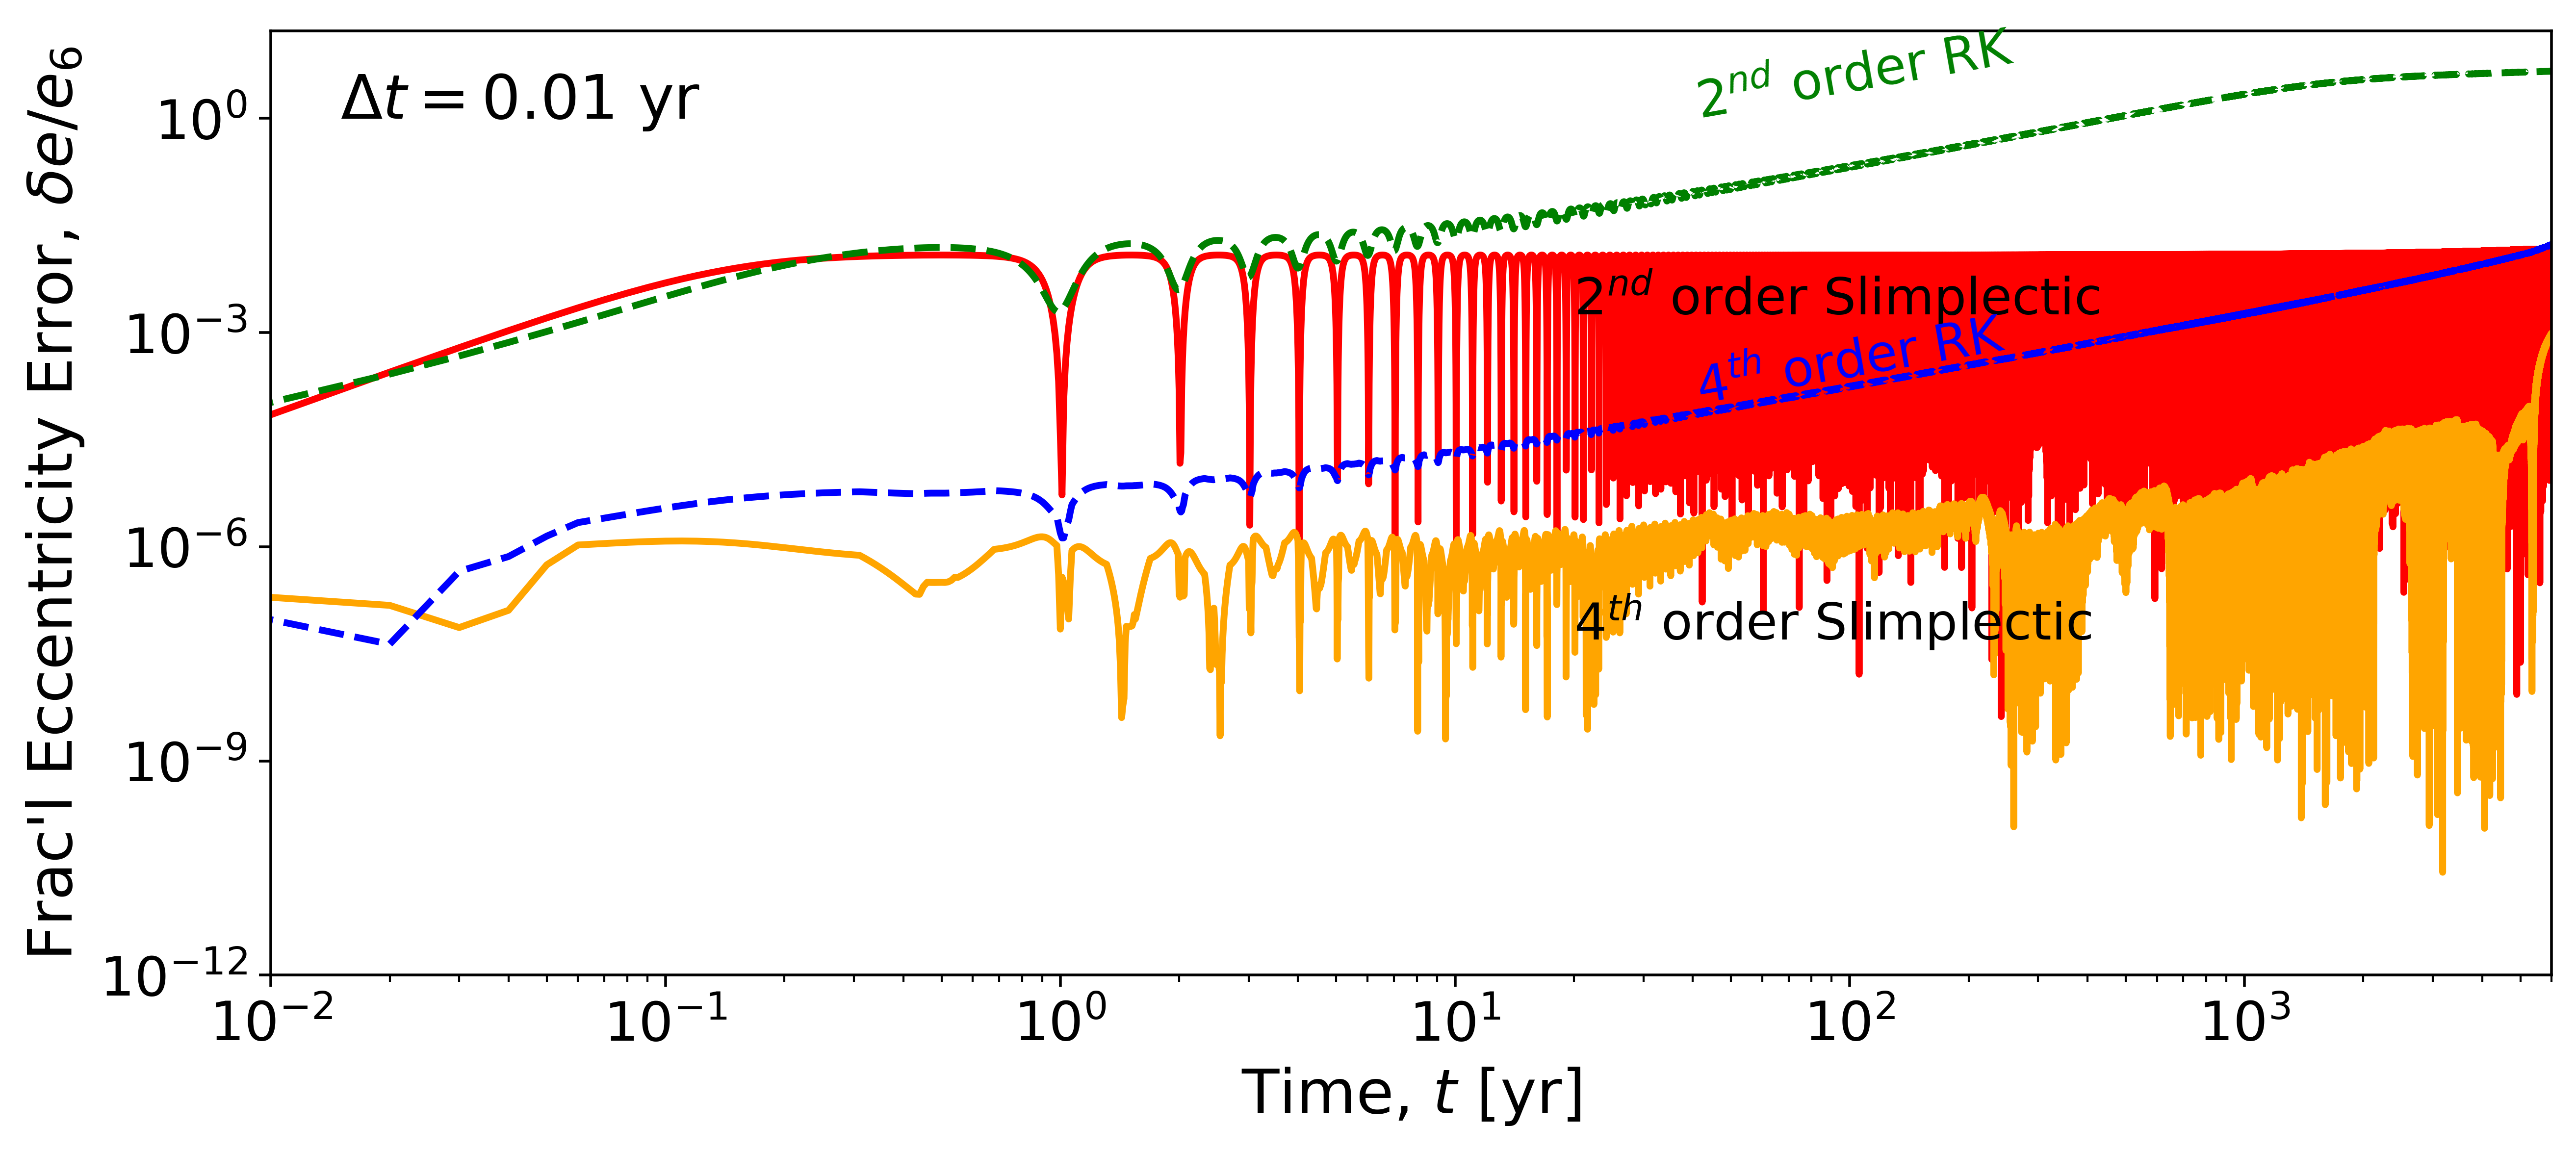

In [19]:
fig3 = plt.figure(figsize=(12, 5), dpi=500)
ax3 = fig3.add_subplot(1, 1, 1)

ax3.set_xlim(0.01, 6000)
ax3.loglog(t, np.abs(e_slim2 / e_slim6 - 1.), 'r-', linewidth=2.0, rasterized=True)
ax3.loglog(t, np.abs(e_slim4 / e_slim6 - 1.), '-', color='orange', linewidth=2.0, rasterized=True)
ax3.loglog(t, np.abs(e_rk2 / e_slim6 - 1.), 'g--', linewidth=2.0, rasterized=True)
ax3.loglog(t, np.abs(e_rk4 / e_slim6 - 1.), 'b--', linewidth=2.0, rasterized=True)

ax3.set_xlabel('Time, $t$ [yr]', fontsize=18)
ax3.set_ylabel('Frac\'l Eccentricity Error, $\delta e/e_6$', fontsize=18)

ax3.text(20, 1.8e-3, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax3.text(20, 0.5e-7, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax3.text(40, 1e-4, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation=10)
ax3.text(40, 1e0, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)

ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.set_yticks([1e-12, 1e-9, 1e-6, 1e-3, 1e0])
ax3.text(0.015, 1e0, r'$\Delta t = 0.01$ yr', fontsize=18, color='black');

In [20]:
#fig3.savefig(plot_path + "PRDrag_Ecc_errorLong.pdf", transparent=True,bbox_inches='tight')